In [1]:
import os
import itertools
import gc

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix

import lightgbm as lgb

%matplotlib inline

In [3]:
test = None
for model in os.listdir('model_to_stack'):
    if test is None:
        test = pd.read_csv(os.path.join('model_to_stack/', model), compression='gzip')
        test.columns = ['object_id'] + [col + model[0] + model[11:13] for col in test.columns[1:]]
    else:
        temp = pd.read_csv(os.path.join('model_to_stack/', model), compression='gzip')
        temp.columns = [col + model[0] + model[11:13] for col in temp.columns]
        test = pd.concat([test, temp[temp.columns[1:]]], axis=1)

In [4]:
train = None
for oof in os.listdir('oof'):
    if train is None:
        train = pd.read_csv(os.path.join('oof/', oof), index_col=0)
        train.columns = [col + oof[0] + oof[-6:-4] for col in train.columns]
    else:
        temp = pd.read_csv(os.path.join('oof/', oof), index_col=0)
        temp.columns = [col + oof[0] + oof[-6:-4] for col in temp.columns]
        train = pd.concat([train, temp], axis=1)

In [6]:
train_y = pd.read_csv('data/preprocessed_train_set_3.csv')

In [7]:
weights = {
     6: 51.973509933774835,
     15: 15.854545454545455,
     16: 8.493506493506494,
     42: 6.57837384744342,
     52: 42.885245901639344,
     53: 261.6,
     62: 16.214876033057852,
     64: 76.94117647058823,
     65: 8.0,
     67: 37.73076923076923,
     88: 21.21081081081081,
     90: 3.3929961089494163,
     92: 32.83682008368201,
     95: 44.84571428571429
}

In [8]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=666)

In [9]:
def train_classifiers(full_train=None, y=None):
    res = []
    clfs = []
    importances = pd.DataFrame()
    oof_preds = np.zeros((len(full_train), np.unique(y).shape[0]))
    for fold_, (trn_, val_) in enumerate(folds.split(y, y)):
        trn_x, trn_y = full_train.iloc[trn_], y.iloc[trn_]
        val_x, val_y = full_train.iloc[val_], y.iloc[val_]

        clf = lgb.LGBMClassifier(**lgb_params)
        clf.fit(
            trn_x, trn_y,
            eval_set=[(trn_x, trn_y), (val_x, val_y)],
            eval_metric=lgb_multi_weighted_logloss,
            verbose=1000,
            early_stopping_rounds=75,
            sample_weight=trn_y.map(weights),
        )
        oof_preds[val_, :] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)
        result = multi_weighted_logloss(val_y, clf.predict_proba(val_x, num_iteration=clf.best_iteration_))
        res.append(result)
        
        imp_df = pd.DataFrame()
        imp_df['feature'] = full_train.columns
        imp_df['gain'] = clf.feature_importances_
        imp_df['fold'] = fold_ + 1
        importances = pd.concat([importances, imp_df], axis=0)
        clfs.append(clf)
        
    print('+' * 80)
    print(np.array(res).mean())
    print(np.array(res).std())
    return np.array(res).mean(), importances, oof_preds, clfs

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def multi_weighted_logloss(y_true, y_preds):
    classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
    class_weight = {6: 1, 15: 2, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 2, 65: 1, 67: 1, 88: 1, 90: 1, 92: 1, 95: 1}
    if len(np.unique(y_true)) > 14:
        classes.append(99)
        class_weight[99] = 2
    y_p = y_preds
    y_ohe = pd.get_dummies(y_true)
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1 - 1e-15)
    y_p_log = np.log(y_p)
    y_log_ones = np.sum(y_ohe.values * y_p_log, axis=0)
    nb_pos = y_ohe.sum(axis=0).values.astype(float)
    class_arr = np.array([class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos

    loss = - np.sum(y_w) / np.sum(class_arr)
    return loss    

def lgb_multi_weighted_logloss(y_true, y_preds):
    classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
    class_weight = {6: 1, 15: 2, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 2, 65: 1, 67: 1, 88: 1, 90: 1, 92: 1, 95: 1}
    if len(np.unique(y_true)) > 14:
        classes.append(99)
        class_weight[99] = 2
    y_p = y_preds.reshape(y_true.shape[0], len(classes), order='F')

    y_ohe = pd.get_dummies(y_true)
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1 - 1e-15)
    y_p_log = np.log(y_p)
    y_log_ones = np.sum(y_ohe.values * y_p_log, axis=0)
    nb_pos = y_ohe.sum(axis=0).values.astype(float)
    class_arr = np.array([class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos

    loss = - np.sum(y_w) / np.sum(class_arr)
    return 'wloss', loss, False

In [10]:
lgb_params = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class': 14,
    'metric': 'multi_logloss',
    'learning_rate': 0.03,
    'subsample': .7,
    'colsample_bytree': .55,
    'reg_alpha': .1,
    'reg_lambda': .01,
    'min_split_gain': 0.02,
    'n_estimators': 1000,
    'silent': 1,
    'verbose': -1,
    'max_depth': 5,
    'min_data_in_leaf': 85
}

In [11]:
m, imp, oof, clfs = train_classifiers(train, train_y['target'])

Training until validation scores don't improve for 75 rounds.
Early stopping, best iteration is:
[192]	training's multi_logloss: 0.238029	training's wloss: 0.227025	valid_1's multi_logloss: 0.560898	valid_1's wloss: 0.498161
Training until validation scores don't improve for 75 rounds.
Early stopping, best iteration is:
[216]	training's multi_logloss: 0.215218	training's wloss: 0.205046	valid_1's multi_logloss: 0.529684	valid_1's wloss: 0.453411
Training until validation scores don't improve for 75 rounds.
Early stopping, best iteration is:
[187]	training's multi_logloss: 0.240534	training's wloss: 0.231392	valid_1's multi_logloss: 0.593406	valid_1's wloss: 0.487309
Training until validation scores don't improve for 75 rounds.
Early stopping, best iteration is:
[181]	training's multi_logloss: 0.250127	training's wloss: 0.240164	valid_1's multi_logloss: 0.585185	valid_1's wloss: 0.491161
Training until validation scores don't improve for 75 rounds.
Early stopping, best iteration is:
[19

Normalized confusion matrix


168

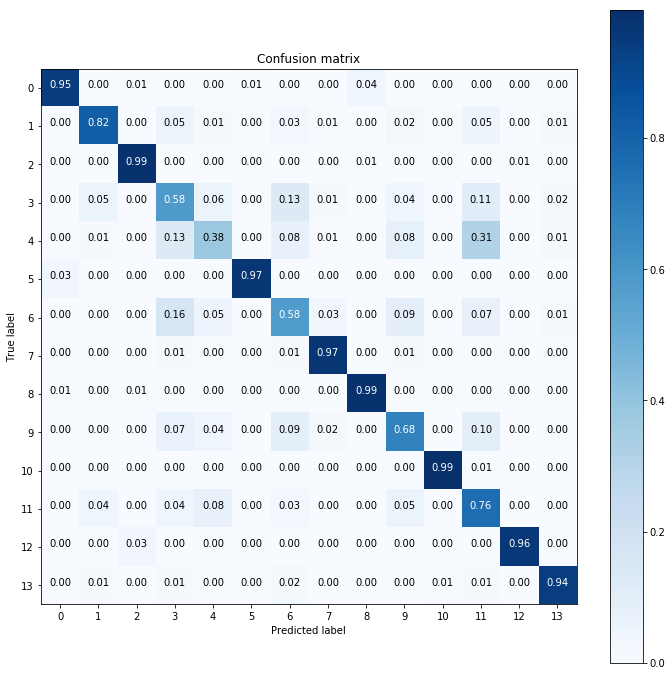

In [13]:
dr = dict(zip(sorted([6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]), range(14)))

cnf_matrix = confusion_matrix(train_y['target'].map(dr), np.argmax(oof, axis=-1))

# Plot normalized confusion matrix
plt.figure(figsize=(12, 12))
foo = plot_confusion_matrix(cnf_matrix, classes=range(14), normalize=True,
                      title='Confusion matrix')
gc.collect()

In [15]:
preds_ = None
for clf in clfs:
    if preds_ is None:
        preds_ = clf.predict_proba(test[train.columns]) 
    else:
        preds_ += clf.predict_proba(test[train.columns]) 

preds_ = preds_ / len(clfs)


preds_99 = np.ones(preds_.shape[0])
for i in range(preds_.shape[1]):
    preds_99 *= (1 - preds_[:, i])

classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
# Create DataFrame from predictions
preds_df_ = pd.DataFrame(preds_, columns=['class_' + str(s) for s in classes])
preds_df_['object_id'] = test['object_id']
preds_df_['class_99'] = 0.23 * preds_99 / np.mean(preds_99) 

In [16]:
preds_df_[['object_id'] + ['class_' + str(s) for s in classes] + ['class_99']]\
.to_csv('stack_final.csv.gz', header=True, index=False, float_format='%.6f', compression='gzip')

In [17]:
gc.collect()

11842